<h1 style="text-align: center;">CS 6476 - Computer Vision </h1>
<h2 style="text-align: center;">Problem Set 4 - Harris, SIFT, RANSAC</h2>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy as cp
import random
import math
import sys
from skimage.transform import warp
SIFT = cv2.xfeatures2d.SIFT_create()


### Part 1: Harris Corners

In [2]:

def gradients(img):
    im = cv2.GaussianBlur(img,(3,3),2)
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    edges_x = cv2.filter2D(im,cv2.CV_64F,kernelx)
    edges_y = cv2.filter2D(im,cv2.CV_64F,kernely)
    return (edges_x,edges_y)


In [4]:


simA = cv2.imread('simA.jpg',0)
transA = cv2.imread('transA.jpg',0)

simAcp = cp.deepcopy(simA)
transAcp = cp.deepcopy(transA)

kernelxsimA,kernelysimA = gradients(simAcp)
kernelxtransA,kernelytransA = gradients(transAcp)

cv2.imwrite('ps4-1-1-1.png',kernelxsimA)
cv2.imwrite('ps4-1-1-2.png',kernelysimA)
cv2.imwrite('ps4-1-1-3.png',kernelxtransA)
cv2.imwrite('ps4-1-1-4.png',kernelytransA)




True

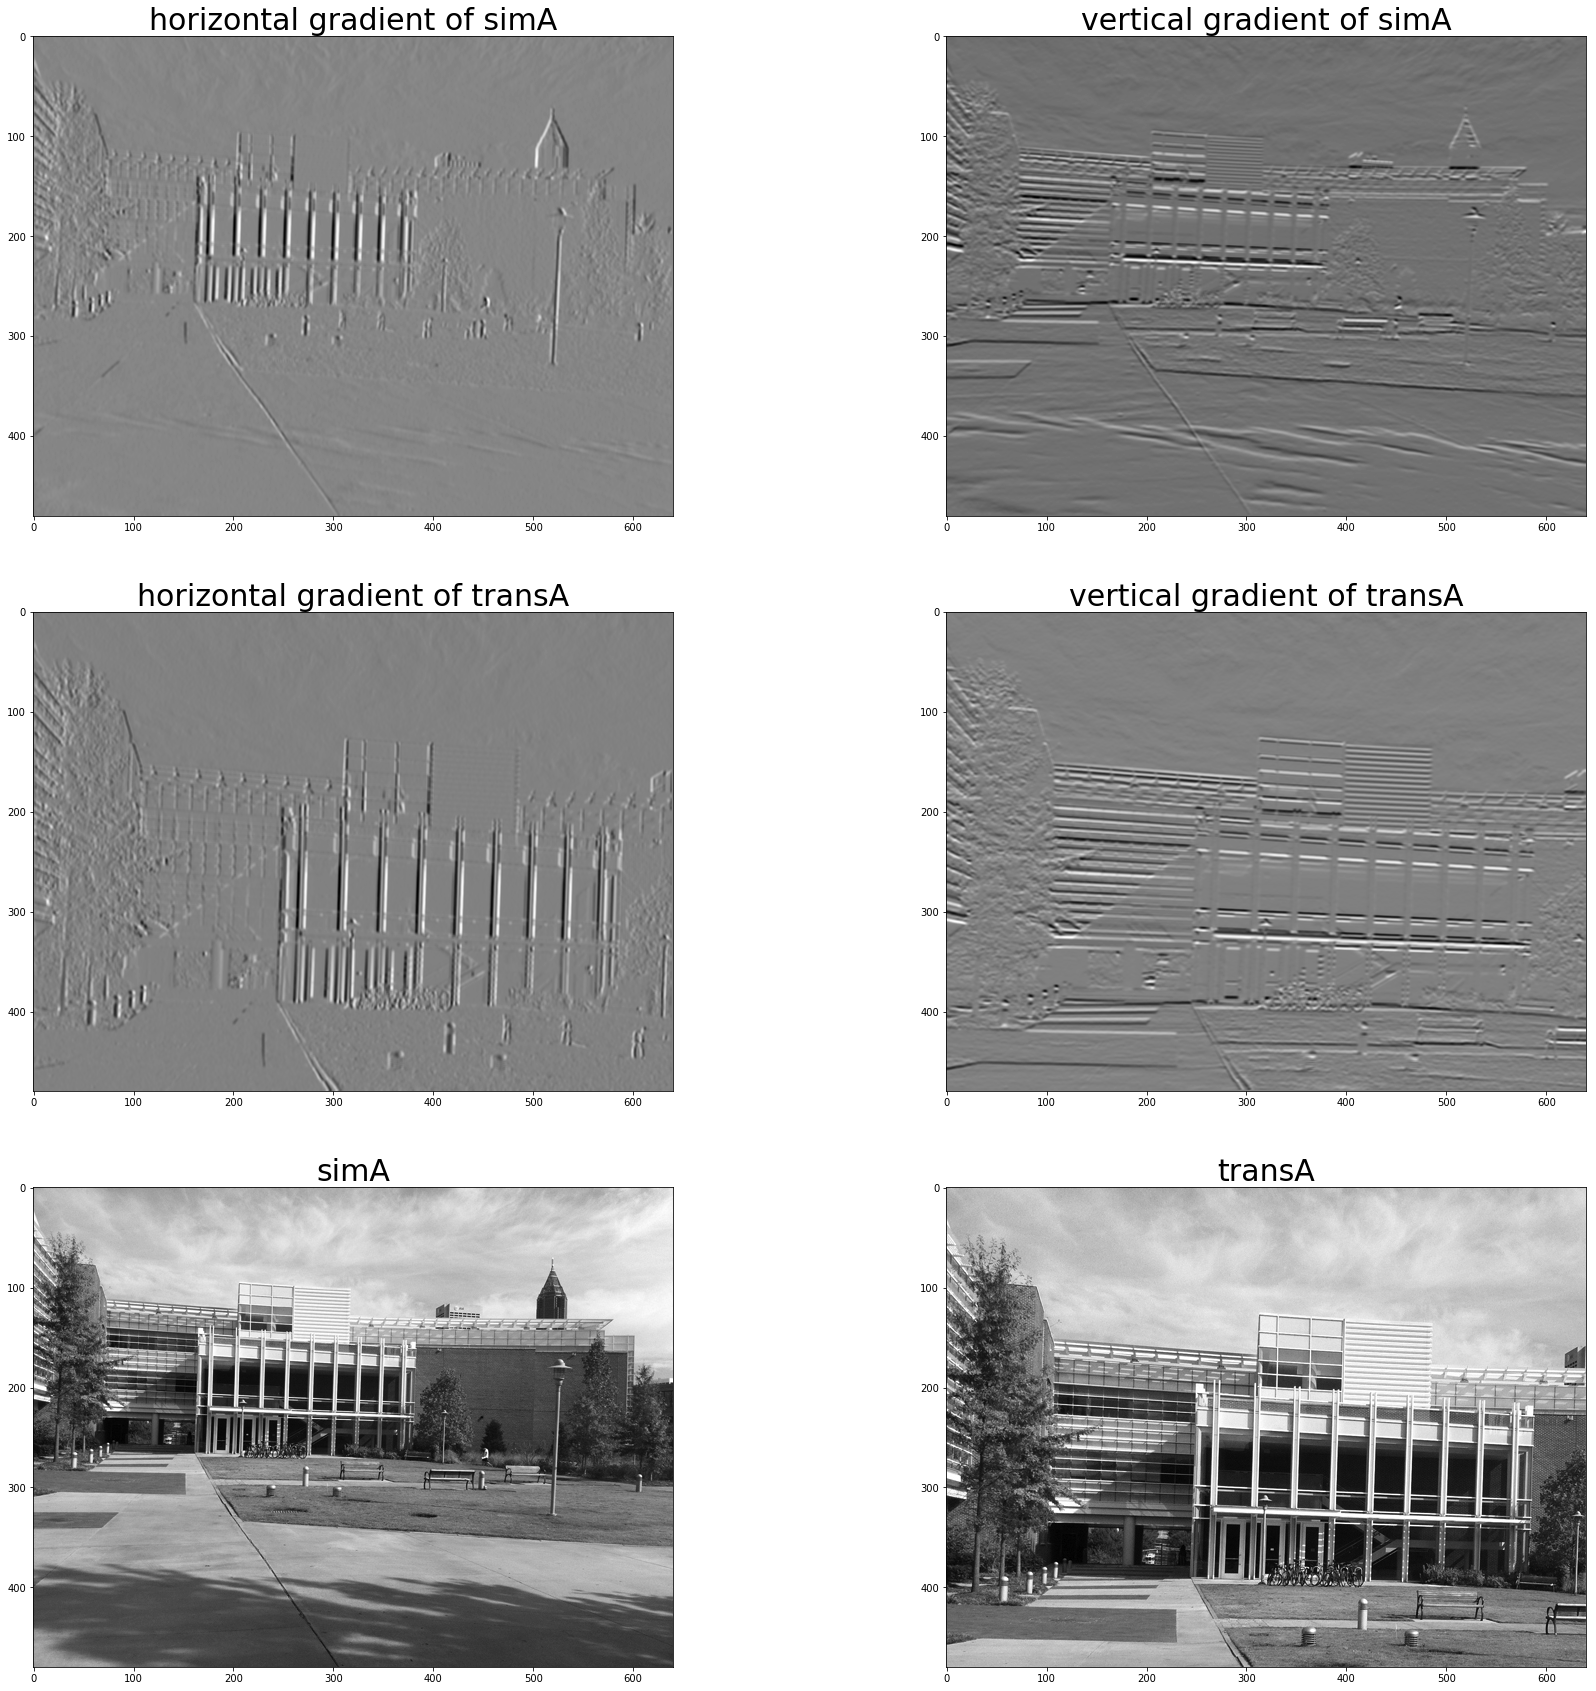

In [7]:
plt.figure(figsize=(30,30))
plt.subplot(3,2,1),plt.imshow(kernelxsimA,cmap='gray'),plt.title('horizontal gradient of simA',fontsize=30)
plt.subplot(3,2,2),plt.imshow(kernelysimA,cmap='gray'),plt.title('vertical gradient of simA',fontsize=30)
plt.subplot(3,2,3),plt.imshow(kernelxtransA,cmap='gray'),plt.title('horizontal gradient of transA',fontsize=30)
plt.subplot(3,2,4),plt.imshow(kernelytransA,cmap='gray'),plt.title('vertical gradient of transA',fontsize=30)
plt.subplot(3,2,5),plt.imshow(simA,cmap='gray'),plt.title('simA',fontsize=30)
plt.subplot(3,2,6),plt.imshow(transA,cmap='gray'),plt.title('transA',fontsize=30)

plt.show()

In [8]:
def harrisValues(Ix,Iy,w_size=5,alpha=0.03):
    Ixy = Ix*Iy
    Ixx = Ix**2
    Iyy = Iy**2
    c = np.zeros((w_size,w_size), dtype=np.float32);
    c[w_size // 2, w_size // 2] = 1.0
    w = cv2.GaussianBlur(c, (w_size,w_size), 0)
    R = np.zeros(Ix.shape).astype(np.float)
    for i in np.arange(w_size//2,Ix.shape[0]-w_size//2):
        for j in np.arange(w_size//2,Ix.shape[1]-w_size//2):     
            mini = i-w_size//2
            maxi = i+w_size//2+1
            minj = j-w_size//2
            maxj = j+w_size//2+1
            Mxy = (w*Ixy[mini:maxi,minj:maxj]).sum()
            M = np.array([[(w*Ixx[mini:maxi,minj:maxj]).sum(),Mxy],[Mxy,(w*Iyy[mini:maxi,minj:maxj]).sum()]])
            R[i,j] = np.linalg.det(M)-alpha*np.square(np.trace(M))
    return R

def norm(im):
    return cv2.normalize(im, im, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def harris(img):
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    R = harrisValues(Ix,Iy)

    return R

In [10]:
simB = cv2.imread('simB.jpg',0)
transB = cv2.imread('transB.jpg',0)


RtransA = harris(transA)
RtransB = harris(transB)

cv2.imwrite("ps4-1-2-1.png",norm(RtransA))
cv2.imwrite('ps4-1-2-2.png',norm(RtransB))

RsimA = harris(simA)
RsimB = harris(simB)

cv2.imwrite("ps4-1-2-3.png",norm(RsimA))
cv2.imwrite('ps4-1-2-4.png',norm(RsimB))

True

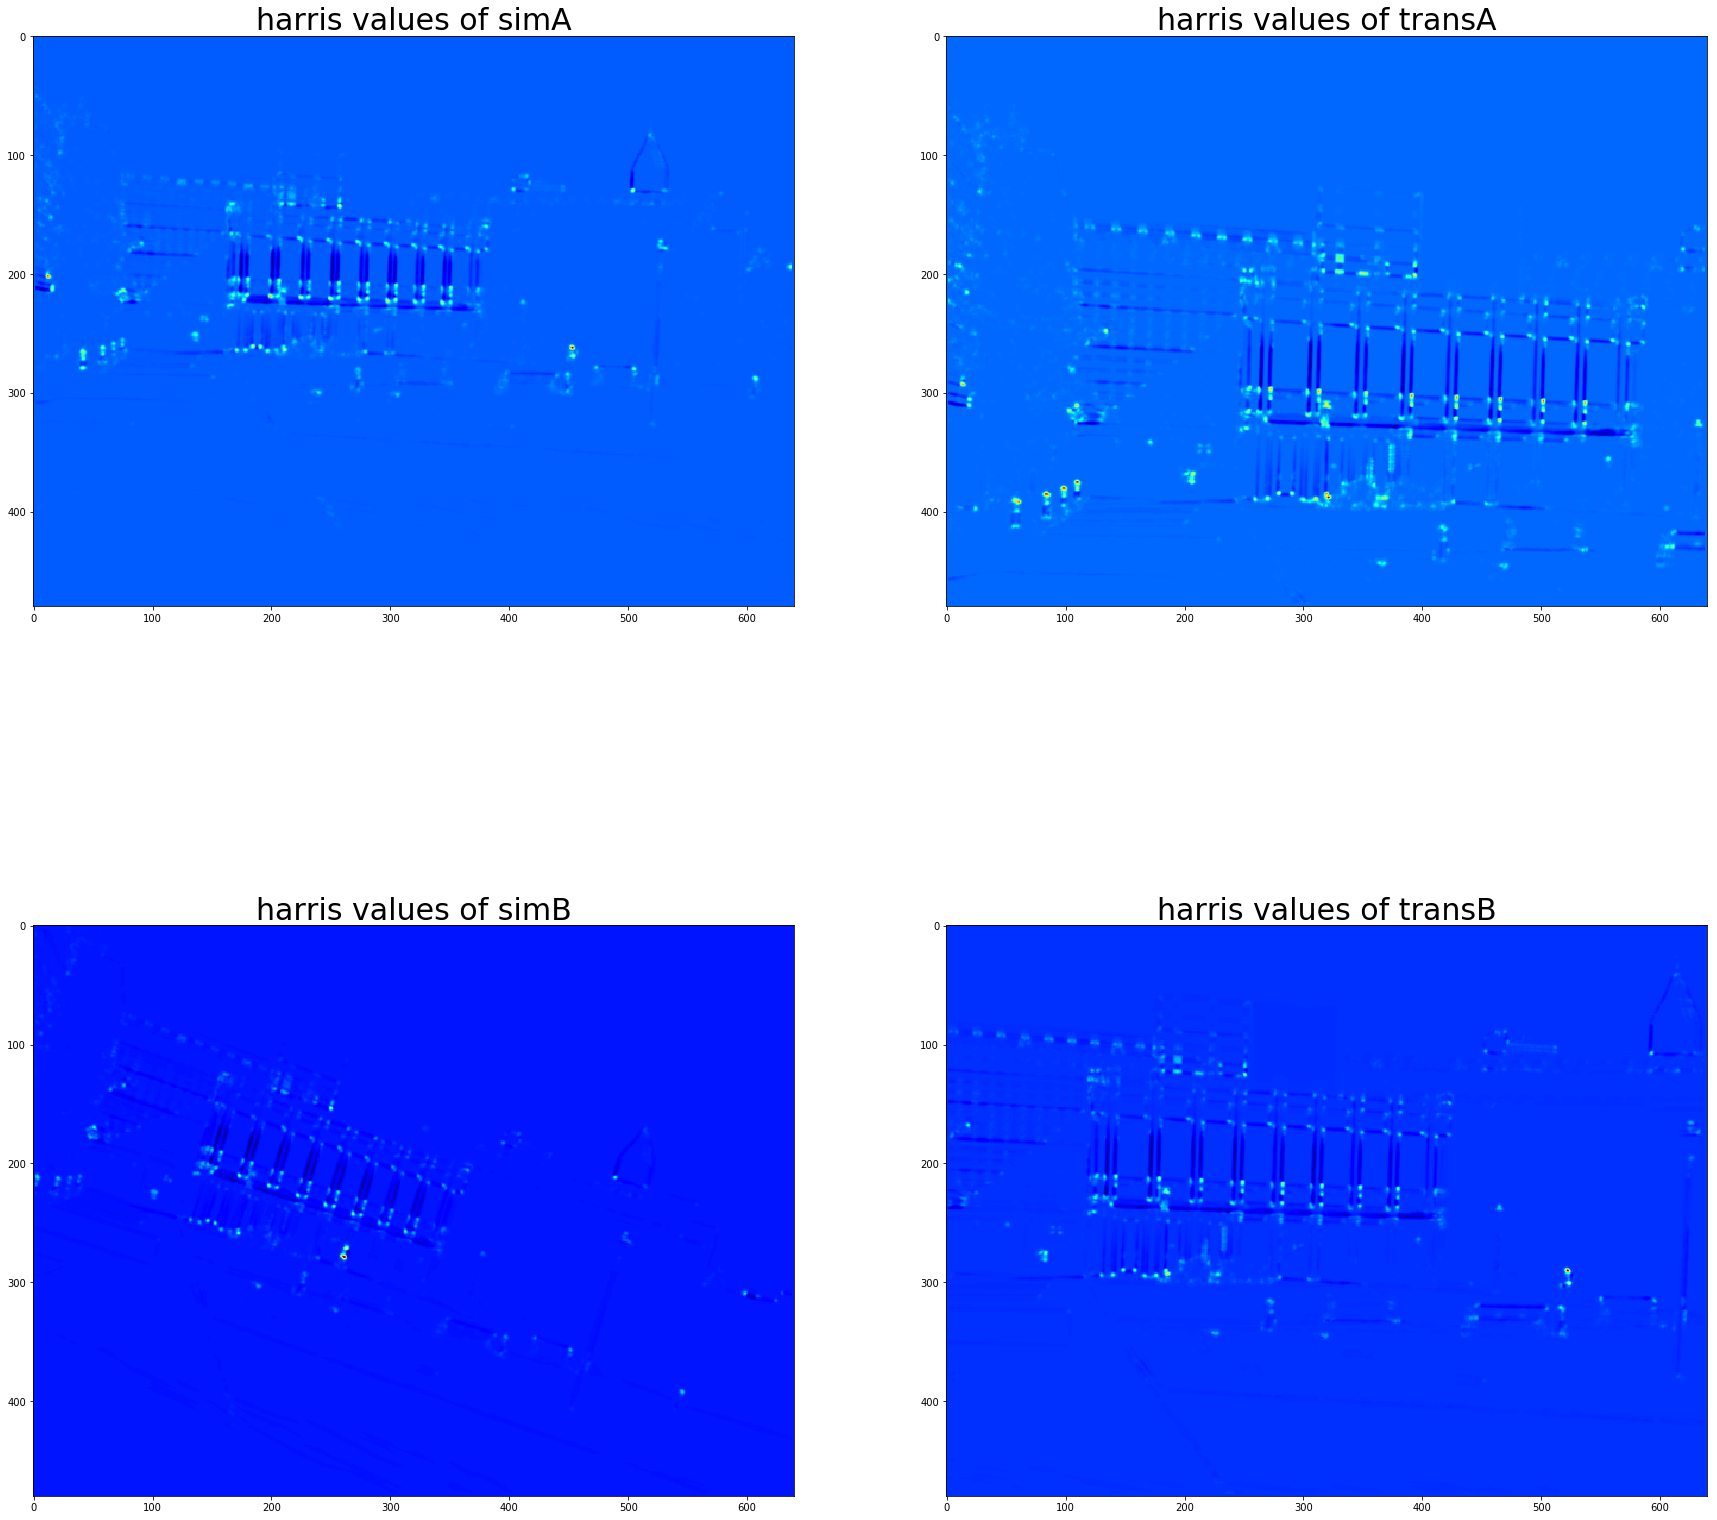

In [11]:
plt.figure(figsize=(30,30))
plt.subplot(2,2,1),plt.imshow(norm(RsimA),cmap='jet'),plt.title('harris values of simA',fontsize=30)
plt.subplot(2,2,2),plt.imshow(norm(RtransA),cmap='jet'),plt.title('harris values of transA',fontsize=30)
plt.subplot(2,2,3),plt.imshow(norm(RsimB),cmap='jet'),plt.title('harris values of simB',fontsize=30)
plt.subplot(2,2,4),plt.imshow(norm(RtransB),cmap='jet'),plt.title('harris values of transB',fontsize=30)

plt.show()

In [12]:
def NMS(R,threshold,radius):
    Rbis = cp.deepcopy(R)
    maxr = np.amax(Rbis)
    threshold = threshold * maxr
    lPotential = []
    lCorners = []
    for i in np.arange(R.shape[0]):
        for j in np.arange(R.shape[1]):
            if( Rbis[i,j]<threshold):
                 Rbis[i,j] = 0
            else:
                lPotential.append((i,j))
        
    for pt in lPotential:
        i = pt[0]
        j = pt[1]
        mini = max(i-radius,0)
        maxi = min(Rbis.shape[0]-1,i+radius)
        minj = max(j-radius,0)
        maxj = min(Rbis.shape[1]-1,j+radius)
            
        if(Rbis[i,j]==Rbis[mini:maxi,minj:maxj].max()):
            lCorners.append((i,j))
            r = Rbis[i,j]
            Rbis[mini:maxi,minj:maxj] = 0
            Rbis[i,j] = r
    return lCorners

def harrisImp(img,threshold=0.1,radius=12):
    R = harris(img)
    return NMS(R,threshold,radius)


In [17]:
def drawCorners(corners,img):
    im = cp.deepcopy(img)
    for p in corners:
        cv2.circle(im,(p[1],p[0]),5,(255,0,0))
    return im

check = cv2.imread('check.bmp',0)
checkRot = cv2.imread('check_rot.bmp',0)
checkCorners = harrisImp(check)
checkRotCorners = harrisImp(checkRot)
simAcorners = harrisImp(simA)
transAcorners =harrisImp(transA)

simBcorners = harrisImp(simB)
transBcorners =harrisImp(transB)


cv2.imwrite('ps4-1-3-1.png',drawCorners(transAcorners,transA))
cv2.imwrite('ps4-1-3-2.png',drawCorners(transBcorners,transB))
cv2.imwrite('ps4-1-3-3.png',drawCorners(simAcorners,simA))
cv2.imwrite('ps4-1-3-4.png',drawCorners(simBcorners,simB))



True

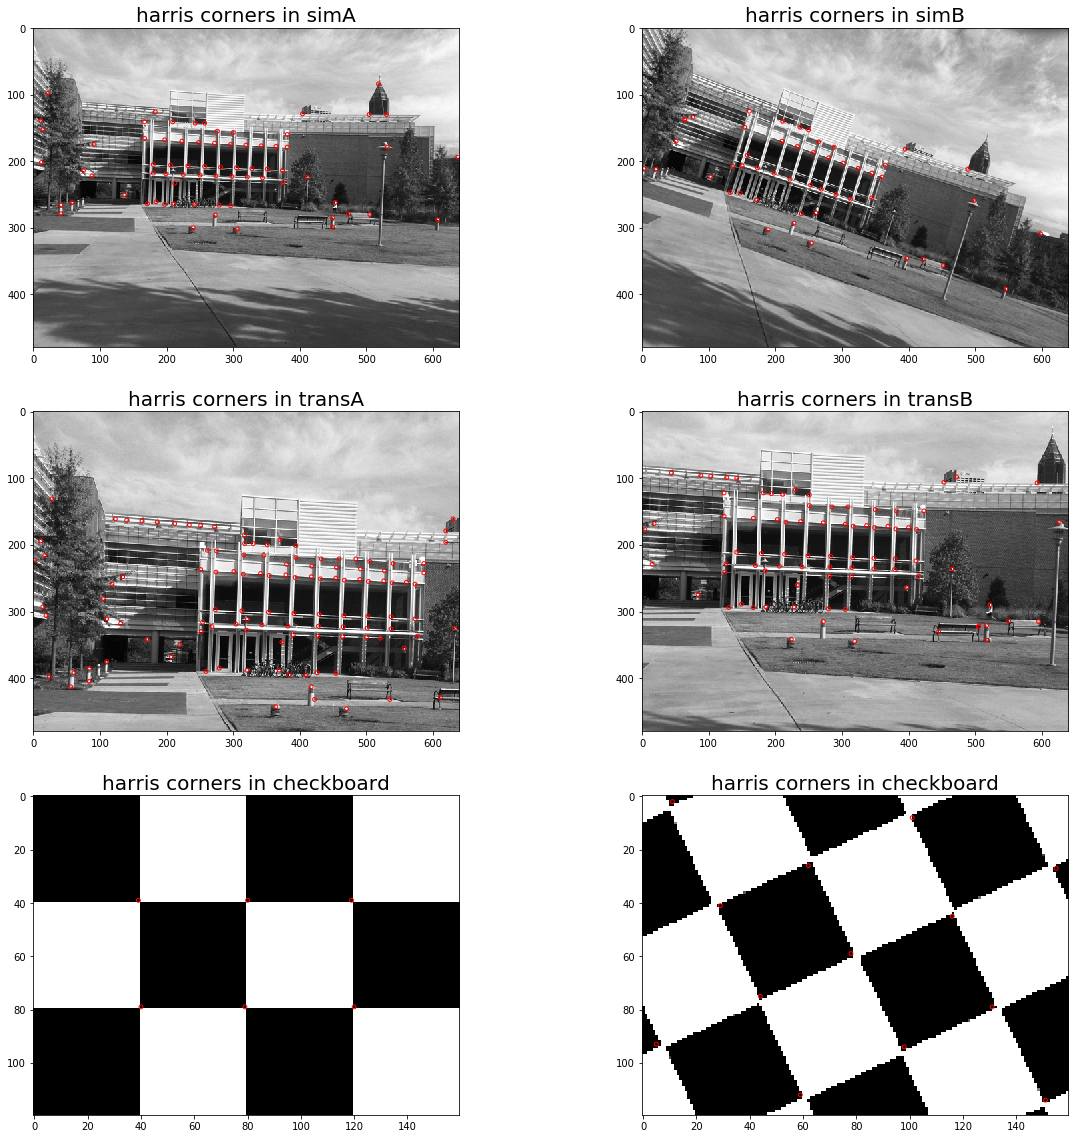

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(simA,cmap='gray'),plt.title('harris corners in simA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simAcorners], 
    y=[pt[0] for pt in simAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,2),plt.imshow(simB,cmap='gray'),plt.title('harris corners in simB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simBcorners], 
    y=[pt[0] for pt in simBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,3),plt.imshow(transA,cmap='gray'),plt.title('harris corners in transA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transAcorners], 
    y=[pt[0] for pt in transAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,4),plt.imshow(transB,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transBcorners], 
    y=[pt[0] for pt in transBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,5),plt.imshow(check,cmap='gray'),plt.title('harris corners in checkboard',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkCorners], 
    y=[pt[0] for pt in checkCorners], 
    s=15, facecolors="none", edgecolors="r"
)

plt.subplot(3,2,6),plt.imshow(checkRot,cmap='gray'),plt.title('harris corners in checkboard',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkRotCorners], 
    y=[pt[0] for pt in checkRotCorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.show()


Unsurprisingly lots of chosen corners are present in the 4 images. However, less corners have been found in simB while harris should be rotation invarient.
Moreover, lots of points are on the building facade which seems logical since this region of the images looks like a sort of grid.

### Part2: SIFT features

In [19]:
def features(img,threshold=0.1):
    keypoints = []
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    O = np.arctan2(Iy,Ix)
    lPoints = harrisImp(im,threshold)
    for p in lPoints:
        kpt = cv2.KeyPoint(p[1], p[0], _size=15, _angle=np.deg2rad(O[p[0],p[1]]))
        keypoints.append(kpt)
    im = cv2.drawKeypoints(im,keypoints,im,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return  (keypoints, im)


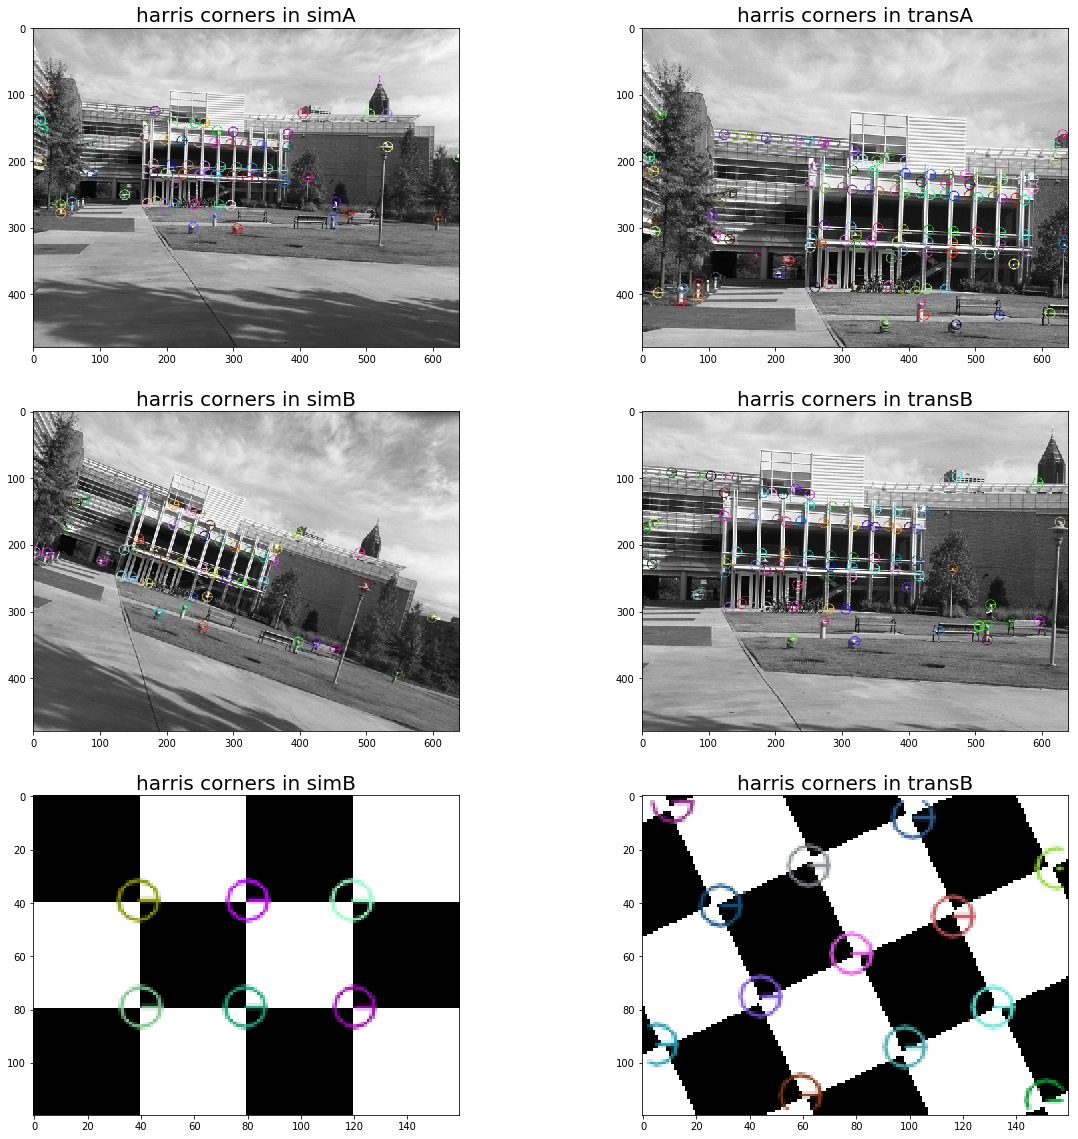

In [20]:
kpSimA,simAsift = features(simA)
kpTransA,transAsift = features(transA)
kpSimB,simBsift = features(simB)
kpTransB,transBsift = features(transB)
kpCheck,checkSift = features(check)
kpCheckRot,checkRotSift = features(checkRot)

cv2.imwrite('ps4-2-1-1.png',transAsift)
cv2.imwrite('ps4-2-1-2.png',transBsift)
cv2.imwrite('ps4-2-1-3.png',simAsift)
cv2.imwrite('ps4-2-1-4.png',simBsift)


plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(simAsift,cmap='gray'),plt.title('harris corners in simA',fontsize=20)
plt.subplot(3,2,2),plt.imshow(transAsift,cmap='gray'),plt.title('harris corners in transA',fontsize=20)
plt.subplot(3,2,3),plt.imshow(simBsift,cmap='gray'),plt.title('harris corners in simB',fontsize=20)
plt.subplot(3,2,4),plt.imshow(transBsift,cmap='gray'),plt.title('harris corners in transB',fontsize=20)
plt.subplot(3,2,5),plt.imshow(checkSift,cmap='gray'),plt.title('harris corners in simB',fontsize=20)
plt.subplot(3,2,6),plt.imshow(checkRotSift,cmap='gray'),plt.title('harris corners in transB',fontsize=20)
plt.show()


In [22]:
def findMatches(img1,img2,kp1,kp2,alpha = 1):
    
    # find the keypoints and descriptors with SIFT
    _, des1 = SIFT.compute(img1,kp1)
    _, des2 = SIFT.compute(img2,kp2)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des2,des1, k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < alpha*n.distance:
            good.append([m])
    
    im = np.zeros((img1.shape[0],img1.shape[1]+img2.shape[1]))
    im[:,:img1.shape[1]]=img1
    im[:,img1.shape[1]:im.shape[1]]=img2
    im = im.astype('uint8')
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    
    for match in good:
        trainId = match[0].trainIdx
        queryId = match[0].queryIdx
        p1 = kp1[trainId].pt
        p2 = kp2[queryId].pt
        y1 = int(p1[1]) 
        x1 = int(p1[0])
        y2 = int(p2[1])
        x2 = int( p2[0]+img1.shape[1])
        color = tuple([random.randint(0,255) for i in range(3)])
        im = cv2.circle(im,(x1,y1),10,color)
        im = cv2.circle(im,(x2,y2),10,color)
        im = cv2.line(im,(x1,y1),(x2,y2),color,2)       
    return im,good


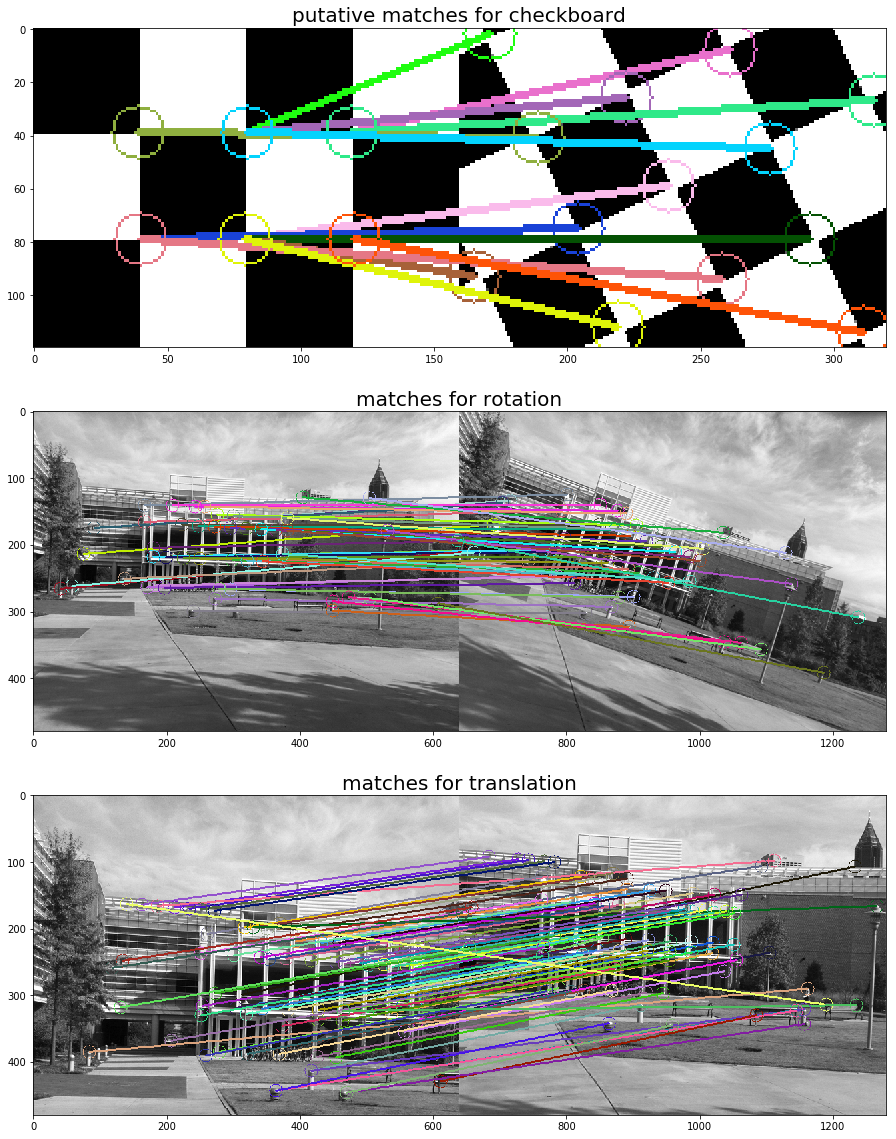

In [25]:
im,matches_c = findMatches(check,checkRot,kpCheck,kpCheckRot)
imA,matches_A = findMatches(simA,simB,kpSimA,kpSimB)
imB,matches_B = findMatches(transA,transB,kpTransA,kpTransB)

cv2.imwrite('ps4-2-2-1.png',imB)
cv2.imwrite('ps4-2-2-2.png',imA)


plt.figure(figsize=(20,20))
plt.subplot(3,1,1),plt.imshow(im),plt.title('putative matches for checkboard',fontsize=20)
plt.subplot(3,1,2),plt.imshow(imA),plt.title('matches for rotation',fontsize=20)
plt.subplot(3,1,3),plt.imshow(imB),plt.title('matches for translation',fontsize=20)
plt.show()

### Part 3: RANSAC

In [27]:
def trans(im1,im2,tolerance,N=sys.maxsize):
    feat1,_ = features(im1,threshold=0.1)
    feat2,_ = features(im2,threshold=0.1)
    _,matches = findMatches(im1,im2,feat1,feat2)
#     print(matches)
    consSet = []
    i = 0
    while(i<N):
        k = random.randint(0,len(matches)-1)
        match = matches[k]
        tempConsSet=[]
        trainId = match[0].trainIdx
        queryId = match[0].queryIdx
        p1 = feat1[trainId].pt
        p2 = feat2[queryId].pt
        y1 = p1[1] 
        x1 = p1[0]
        y2 = p2[1]
        x2 = p2[0]
        dX = abs(x1-x2)
        dY = abs(y1-y2)
        for match2 in matches:
            trainId = match2[0].trainIdx
            queryId = match2[0].queryIdx
            p1 = feat1[trainId].pt
            p2 = feat2[queryId].pt
            diX = abs(p1[0]-p2[0])
            diY = abs(p1[1]-p2[1])
            if(abs(diX-dX)<tolerance and abs(diY-dY)<tolerance):
                tempConsSet.append((p1,p2))
        if(len(tempConsSet)>len(consSet)):
            consSet = cp.deepcopy(tempConsSet)
            bestMatch = (dX,dY)
            e = (len(matches)-len(consSet))/len(matches)
            N = int(math.log(0.01)/math.log(1-(1-e)))*500
        i+=1
    im = np.zeros((im1.shape[0],im1.shape[1]+im2.shape[1]))
    im[:,:im1.shape[1]]=im1
    im[:,im1.shape[1]:im.shape[1]]=im2
    im = im.astype('uint8')
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    score = len(consSet)/len(matches) * 100
#     print(consSet)
    for match in consSet:
        x1 = int(match[0][0])
        y1 = int(match[0][1])
        x2 = int(match[1][0]+im1.shape[1])
        y2 = int(match[1][1])
        color = tuple([random.randint(0,255) for i in range(3)])
        im = cv2.circle(im,(x1,y1),10,color)
        im = cv2.circle(im,(x2,y2),10,color)
        im = cv2.line(im,(x1,y1),(x2,y2),color,2)       
    M = np.array([[1,0,dX],[0,1,dY]])
    return M,im,score

In [77]:
Mtrans,imMatchesTrans,score = trans(transA,transB,12)
print("Best translation matrix:\n",Mtrans)
print("score = ",score,"%")

Best translation matrix:
 [[  1.   0. 137.]
 [  0.   1.  88.]]
score =  40.243902439024396 %


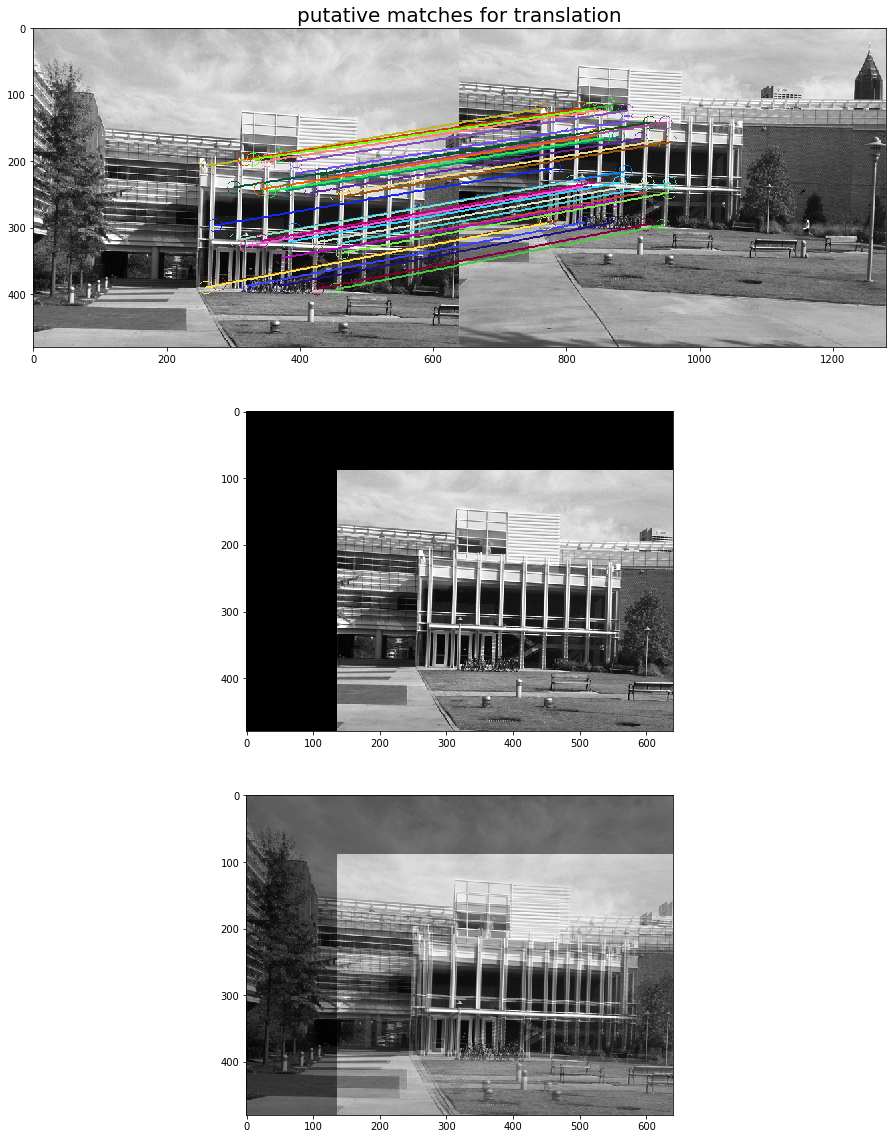

In [78]:
imTrans = cv2.warpAffine(transB,Mtrans,(transB.shape[1],transB.shape[0]))
cv2.imwrite('ps4-3-1-1.png',cv2.addWeighted(transA, 0.5, imTrans, 0.5, 0.0))
cv2.imwrite('ps4-3-1-2.png',imMatchesTrans)

plt.figure(figsize=(20,20))
plt.subplot(3,1,1),plt.imshow(imMatchesTrans),plt.title('putative matches for translation',fontsize=20)
plt.subplot(3,1,2),plt.imshow(imTrans,cmap='gray')
plt.subplot(3,1,3),plt.imshow(cv2.addWeighted(transA, 0.5, imTrans, 0.5, 0.0),cmap='gray')

plt.show()

In [45]:
def computeMatrix(match1,match2,feat1,feat2):
    # 1st match points
    trainId1 = match1[0].trainIdx
    queryId1 = match1[0].queryIdx
    p11 = feat1[trainId1].pt
    p21 = feat2[queryId1].pt
    y11 = p11[1] 
    x11 = p11[0]
    y21 = p21[1]
    x21 = p21[0]
    # 2nd match points
    trainId2 = match2[0].trainIdx
    queryId2 = match2[0].queryIdx
    p12 = feat1[trainId2].pt
    p22 = feat2[queryId2].pt
    y12 = p12[1] 
    x12 = p12[0]
    y22 = p22[1]
    x22 = p22[0]
    x = np.asarray([x21,y21,x22,y22])
    A = np.asarray([[x11,-y11,1,0],[y11,x11,0,1],[x12,-y12,1,0],[y12,x12,0,1]])
    M = np.linalg.lstsq(A,x,rcond=None)[0]
    M = np.array([[M[0],-M[1],M[2]],[M[1],M[0],M[3]]])
    return M,(p11,p21,p12,p22)

def error(point1,point2,M):
    M = M.reshape(3,2)
    point1 = np.array([point1[0],point1[1]])
    np.append(point1,0)
    proj = np.dot(M,point1)
    return np.sqrt((proj[0]-point2[0])**2 + (proj[1]-point2[1])**2)

def similarity(im1,im2,tolerance,N=sys.maxsize):
    feat1,_ = features(im1,0.09)
    feat2,_ = features(im2,0.09)
    _,matches = findMatches(im1,im2,feat1,feat2)
#     np.random.shuffle(matches)
    
    consSet = []
    i = 0
    while(i<N):
        tempConsSet=[]
#         indices = random.sample(range(len(matches)), 2)
        indices = np.random.choice(len(matches),2)
#         print("indices = ",indices)
        match1 = matches[indices[0]]
        match2 = matches[indices[1]]
        tempM,_ = computeMatrix(match1,match2,feat1,feat2)
        for match3 in matches:
            trainId = match3[0].trainIdx
            queryId = match3[0].queryIdx
            p1 = feat1[trainId].pt
            p2 = feat2[queryId].pt
            e = error(p1,p2,tempM)
            if ( e < tolerance ):
                tempConsSet.append((p1,p2))
        if(len(tempConsSet)>len(consSet)):
            consSet = cp.deepcopy(tempConsSet)
            bestMatch = tempM
            e = (len(matches)-len(consSet))/len(matches)
            N = int((math.log(0.01)/math.log(1-(1-e)**2)))*500
        i+=1
    im = np.zeros((im1.shape[0],im1.shape[1]+im2.shape[1]))
    im[:,:im1.shape[1]]=im1
    im[:,im1.shape[1]:im.shape[1]]=im2
    im = im.astype('uint8')
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    score = len(consSet)/len(matches) * 100
    for match in consSet:
        x1 = int(match[0][0])
        y1 = int(match[0][1])
        x2 = int(match[1][0]+im1.shape[1])
        y2 = int(match[1][1])
        color = tuple([random.randint(0,255) for i in range(3)])
        im = cv2.circle(im,(x1,y1),10,color)
        im = cv2.circle(im,(x2,y2),10,color)
        im = cv2.line(im,(x1,y1),(x2,y2),color,2)
    return bestMatch,consSet,im,score

In [65]:
M,matches,imRot,score = similarity(simA,simB,73)

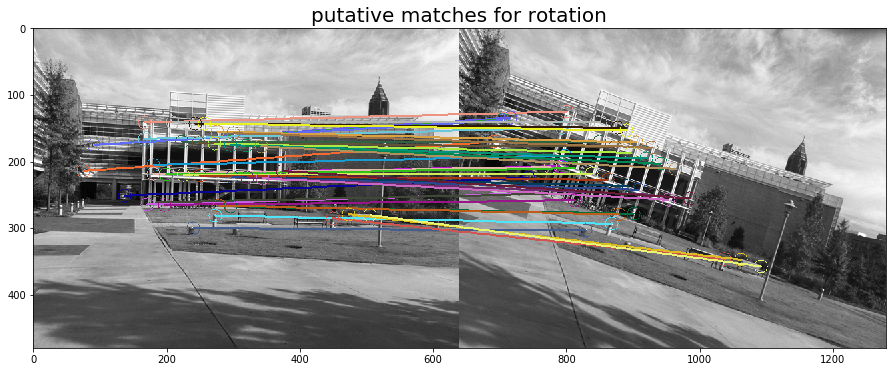

In [66]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1),plt.imshow(imRot),plt.title('putative matches for rotation',fontsize=20)
plt.show()

In [67]:
cv2.imwrite('ps4-3-2-1.png',imRot)
print("score = ", score,"%")

score =  76.47058823529412 %


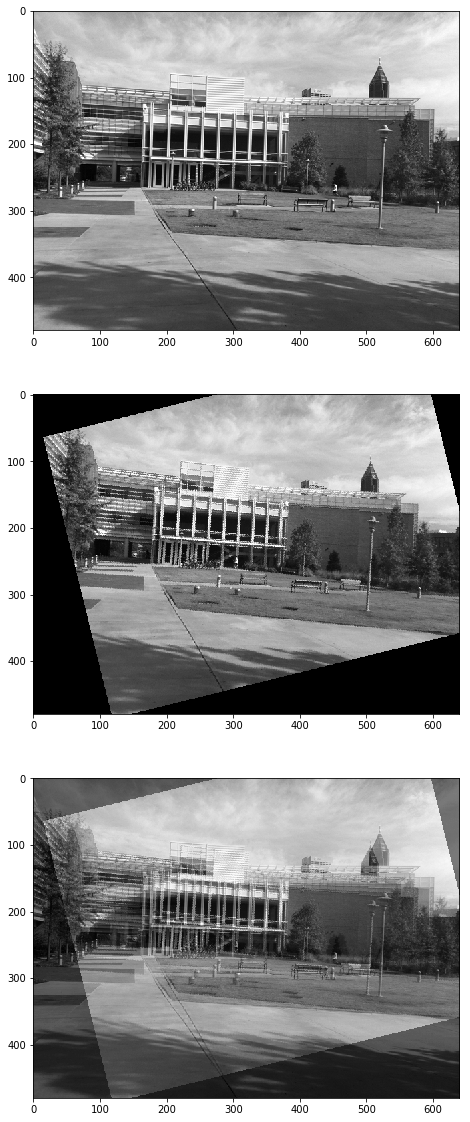

In [68]:
imTransform = cv2.warpAffine(simB,M.astype(np.float64),(simB.shape[1],simB.shape[0]),
                                 flags=cv2.WARP_INVERSE_MAP)

cv2.imwrite('ps4-3-2-2.png',cv2.addWeighted(simA, 0.5, imTransform, 0.5, 0.0))
plt.figure(figsize=(20,20))
    
plt.subplot(3,1,1),plt.imshow(simA,cmap='gray')
plt.subplot(3,1,2),plt.imshow(imTransform,cmap='gray')
plt.subplot(3,1,3),plt.imshow(cv2.addWeighted(simA, 0.5, imTransform, 0.5, 0.0), cmap="gray")
plt.show()


In [69]:
print('transformation matrix for best consensus set :\n',M)

transformation matrix for best consensus set :
 [[  1.07186869  -0.26436843   0.69595241]
 [  0.26436843   1.07186869 -73.2536917 ]]
